In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories using raw strings
male_dir = r'/content/drive/MyDrive/gender_dataset/male'
female_dir = r'/content/drive/MyDrive/gender_dataset/female'
dataset_dir = r'/content/drive/MyDrive/gender_dataset'

# Create a data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_data = datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [8]:
# Load a pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
5/5 [==============================] - 140s 28s/step - loss: 6.9698 - accuracy: 0.5000 - val_loss: 4.8752 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 132s 28s/step - loss: 2.7793 - accuracy: 0.4812 - val_loss: 1.3776 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 129s 27s/step - loss: 1.2212 - accuracy: 0.5063 - val_loss: 0.4573 - val_accuracy: 0.7750
Epoch 4/10
5/5 [==============================] - 135s 28s/step - loss: 0.6222 - accuracy: 0.6625 - val_loss: 0.6001 - val_accuracy: 0.6750
Epoch 5/10
5/5 [==============================] - 130s 27s/step - loss: 0.4001 - accuracy: 0.8000 - val_loss: 0.6128 - val_accuracy: 0.6500
Epoch 6/10
5/5 [==============================] - 132s 27s/step - loss: 0.3919 - accuracy: 0.8250 - val_loss: 0.3830 - val_accuracy: 0.8000
Epoch 7/10
5/5 [==============================] - 131s 28s/step - loss: 0.3294 - accuracy: 0.8250 - val_loss: 0.3341 - val_accuracy: 0.8500
Epoch 8/10
5/5 [====

2/2 [==============================] - 26s 4s/step
              precision    recall  f1-score   support

        Male       0.31      0.25      0.28        20
      Female       0.38      0.45      0.41        20

    accuracy                           0.35        40
   macro avg       0.34      0.35      0.34        40
weighted avg       0.34      0.35      0.34        40



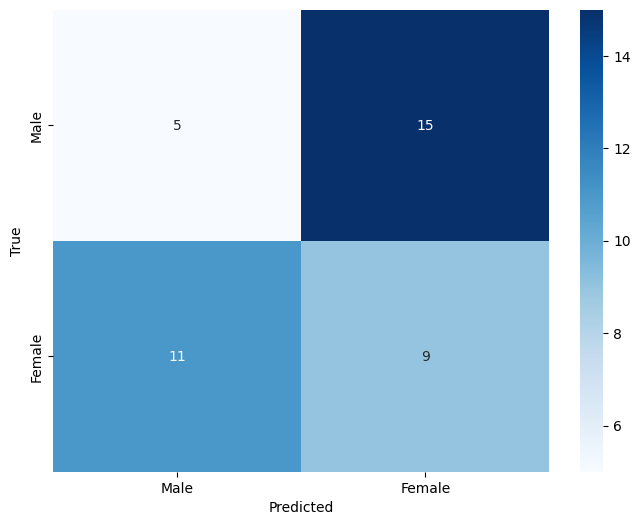

In [10]:
# Evaluate the model on validation data
val_preds = model.predict(val_data)
val_labels = val_data.classes
val_preds = np.where(val_preds > 0.5, 1, 0)

# Print classification report
print(classification_report(val_labels, val_preds, target_names=['Male', 'Female']))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


**Confusion matrix here shows that our image classification model is more biased towards female than male.**

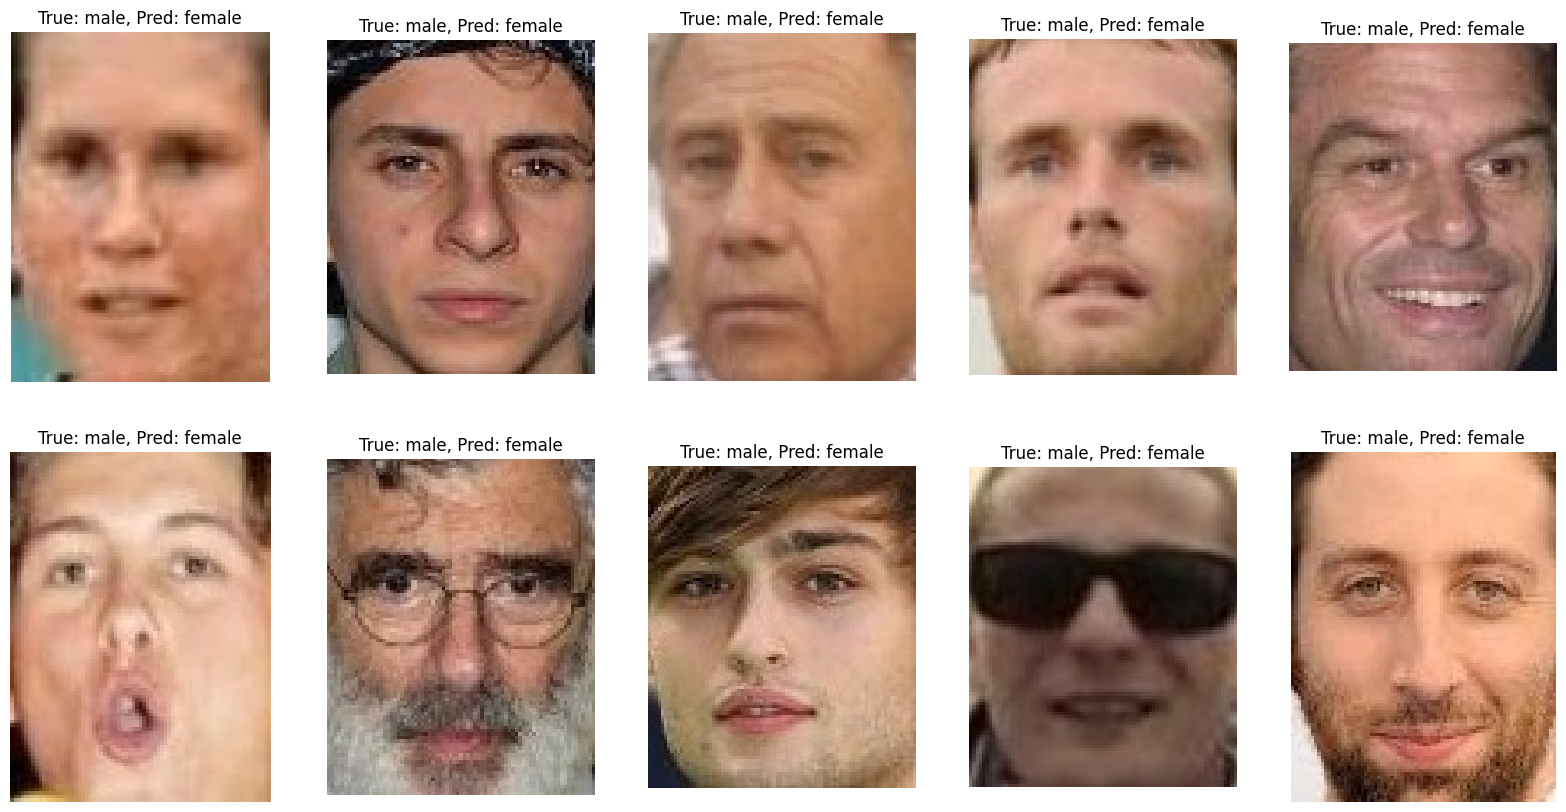

In [11]:
!pip install opencv-python-headless

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

val_preds = np.argmax(val_preds, axis=1) if len(val_preds.shape) > 1 else val_preds

# Get the filenames of the validation data
val_filenames = val_data.filenames

# Identify misclassified images
misclassified_indices = np.where(val_preds != val_labels)[0]

# Plot misclassified images
def plot_misclassified_images(data_gen, misclassified_indices, val_filenames, class_names, n_images=10):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(misclassified_indices[:n_images]):
        img_path = os.path.join(data_gen.directory, val_filenames[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_names[val_labels[idx]]
        pred_label = class_names[val_preds[idx]]

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')

    plt.show()

# Define class names
class_names = list(val_data.class_indices.keys())

# Plot misclassified images
plot_misclassified_images(val_data, misclassified_indices, val_filenames, class_names)


**Above images show the true label and predicted label for the  misclassified images for our model**

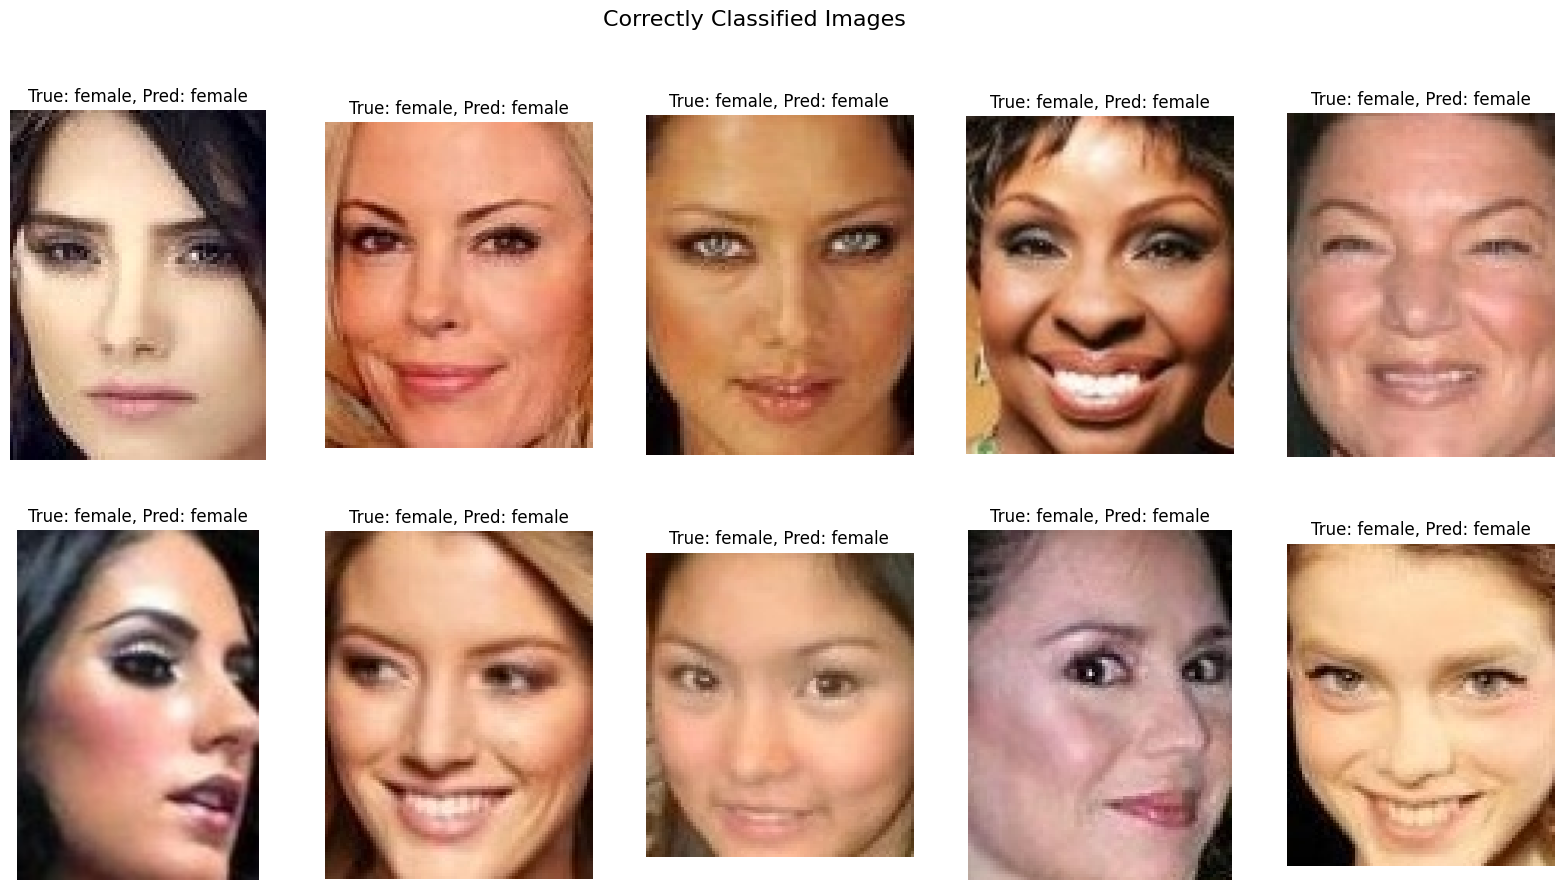

In [12]:
import matplotlib.pyplot as plt
import cv2

# Identify correctly classified images
correctly_classified_indices = np.where(val_preds == val_labels)[0]

# Function to plot images
def plot_images(data_gen, indices, val_filenames, class_names, title, n_images=10):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices[:n_images]):
        img_path = os.path.join(data_gen.directory, val_filenames[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_names[val_labels[idx]]
        pred_label = class_names[val_preds[idx]]

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.show()

# Define class names
class_names = list(val_data.class_indices.keys())

# Plot correctly classified images
plot_images(val_data, correctly_classified_indices, val_filenames, class_names, title="Correctly Classified Images")


**Above images show the true label and predicted label for the correctly classified images for our model**